In [2]:
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

database = 'qardio'
host = '127.0.0.1'
user = 'root'
password = 'Party100'
url = f'mysql+mysqlconnector://{user}:{password}@{host}/{database}'
engine = sqlalchemy.create_engine(url, echo=True)
conn = engine.connect()

pd.set_option('display.max_columns', 500)

2023-06-22 15:08:35,765 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2023-06-22 15:08:35,766 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 15:08:35,768 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2023-06-22 15:08:35,769 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-06-22 15:08:35,770 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2023-06-22 15:08:35,771 INFO sqlalchemy.engine.Engine [raw sql] {}


In [9]:
# query database
sql = """
SELECT c.date,
	c.monthstart,
	e.*
FROM calendar c
LEFT JOIN emails e ON c.date = e.date_sent
WHERE c.date >= (SELECT MIN(date_sent) FROM emails)
	AND c.date <= (SELECT MAX(date_sent) FROM emails)
ORDER BY c.date;
"""

all_data = pd.read_sql(sql=sql,
                       con=conn,
                       parse_dates=['date'],
                       index_col='date')

2023-06-22 15:15:16,278 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2023-06-22 15:15:16,317 INFO sqlalchemy.engine.Engine [cached since 400.5s ago] {'table_schema': 'qardio', 'table_name': '\nSELECT c.date,\n\tc.monthstart,\n\te.*\nFROM calendar c\nLEFT JOIN emails e ON c.date = e.date_sent\nWHERE c.date >= (SELECT MIN(date_sent) FROM emails)\n\tAND c.date <= (SELECT MAX(date_sent) FROM emails)\nORDER BY c.date;\n'}
2023-06-22 15:15:16,324 INFO sqlalchemy.engine.Engine 
SELECT c.date,
	c.monthstart,
	e.*
FROM calendar c
LEFT JOIN emails e ON c.date = e.date_sent
WHERE c.date >= (SELECT MIN(date_sent) FROM emails)
	AND c.date <= (SELECT MAX(date_sent) FROM emails)
ORDER BY c.date;

2023-06-22 15:15:16,326 INFO sqlalchemy.engine.Engine [raw sql] {}


In [18]:
all_data.head()

,monthstart,campaign_name,date_sent,subject_line,subscribers,country,recipients,opens,open_rate,clicks,...,qardiotemp,qardiospo2,qa_case,qa+qbx_bundle,qa+qb_bundle,qa+spo2,qtemp+spo2,ultimate_bundle,qardio_core,total_quantity
date,,,,,,,,,,,,,,,,,,,,,
2022-01-04,2022-01-01,NY_22_E1_Privy_AU,2022-01-04,Start the new year with your full-body health ...,Shopify,AU,2189.0,786.0,35.91,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,2022-01-01,NY_22_E1_Privy_EU,2022-01-04,Start the new year with your full-body health ...,Shopify,EU,1906.0,835.0,43.81,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,2022-01-01,NY_22_E1_Privy_UK,2022-01-04,Start the new year with your full-body health ...,Shopify,UK,2422.0,936.0,38.65,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,2022-01-01,NY_22_E1_GR,2022-01-04,Start the new year with your full-body health ...,NSL,GR,7543.0,2154.0,28.56,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,2022-01-01,NY_22_E1_FR,2022-01-04,Start the new year with your full-body health ...,NSL,FR,12087.0,3254.0,26.92,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Review impact of increasing recipients on revenue

<Axes: xlabel='recipients', ylabel='revenue'>

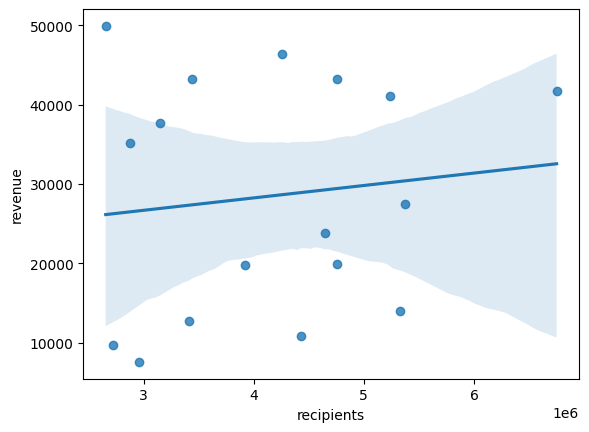

In [17]:
monthly = pd.DataFrame(all_data.groupby('monthstart').aggregate({'recipients': 'sum', 'revenue': 'sum'}))
monthly = monthly.loc[monthly['revenue'] < 80000, :]
sns.regplot(data=monthly, x='recipients', y='revenue')

In [ ]:
monthly = pd.DataFrame(all_data.groupby('monthstart').aggregate({'recipients': 'sum', 'unsub': 'sum'}))
monthly = monthly.loc[monthly['revenue'] < 80000, :]
sns.regplot(data=monthly, x='recipients', y='revenue')